# Prompt #3

#### An empirical observation known as Zipf’s law is often used to describe the distribution of word frequencies in text corpora. Do you see evidence of Zipf’s law in the summaries?

For this prompt I will be:

 - Tokenizing the corpus of summaries
 - Finding frequency counts for each word
 - Enumerating and ordering those frequency counts
 - Looking at both qualitative and quantitave measures in search of evidence for the presence of Zipfian distribution

First note that Zipf's law states the a word's frequency is inversely proportional to its rank in the frequency table. E.g. if and is rank 3 is occurs 1/3 the amount of times that the highest ranked word occurs. This case represents when the parameter s = 1 where occurrance is $1/n^{s}$ amount the highest rank. Other datasets see a Zipfian distribution with differing s.

In [158]:
import pandas as pd
import numpy as np
from scipy.stats import kstest
import string
import matplotlib.pyplot as plt
%matplotlib inline

movies = pd.read_csv("movie_data.csv")

movies.head(5)

C:\Users\jacobmcc\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


,id,title,release_date,box_office_revenue,runtime,genres,summary
0,0,Ghosts of Mars,2001-08-24,14010832.0,98.0,"[Space western, Horror, Supernatural, Thriller...","Set in the second half of the 22nd century, th..."
1,1,White Of The Eye,1987,NaN,110.0,"[Erotic thriller, Psychological thriller, Thri...",A series of murders of rich young women throug...
2,2,A Woman in Flames,1983,NaN,106.0,[Drama],"Eva, an upper class housewife, becomes frustra..."
3,3,The Sorcerer's Apprentice,2002,NaN,86.0,"[Adventure, Fantasy, World cinema, Family Film]","Every hundred years, the evil Morgana returns..."
4,4,Little city,1997-04-04,NaN,93.0,"[Romance Film, Ensemble Film, Comedy-drama, Co...","Adam, a San Francisco-based artist who works a..."


To begin let's make a dictionary with words as keys and total count across the entire corpus as values. We use the same tokenizer as in our first question.

In [165]:
def tokenizer(blob):
    
    translator = str.maketrans({key: None for key in string.punctuation})
    tokenized = blob.lower().replace("-"," ").strip('"-\'«').translate(translator).split()
    
    return tokenized

In [160]:
counts = {}

for summary in movies['summary']:
    for word in tokenizer(summary):
        counts[word] = counts.get(word, 0) + 1

Now dictionaries are inherently orderless but we need an ordering to establish rank. We can do this by creating a list of $(rank, word, count)$ tuples starting with rank 1 and descending all the way down to rank $len(counts)$.

We also create "zipf" which is a list constructed to perfectly follow Zipf's distribution using our corpus and starting with the starting value found in our data.

In [161]:
#sorted ensures we see ordered data. This ordering is preserved in future list comprehensions
ordered = [(n + 1, word, counts[word]) for n, word in enumerate(sorted(counts, key=counts.get, reverse = True))]

zipf = [(n + 1, word, max(counts.values())/(n + 1)) 
        for n, word in enumerate(sorted(counts, key=counts.get, reverse = True))]

Before we get into any quantitative measures for evidence of Zipf's law occurring in our data, first let's look at log-normed plots of both $ordered$ and $zipf$ to see if they look anywhere close to each other.

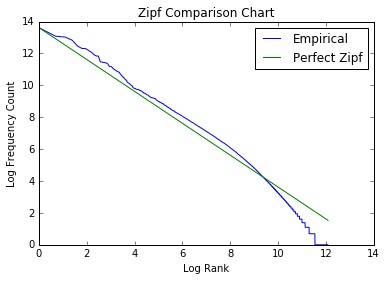

In [162]:
x_ordered = np.log([xs[0] for xs in ordered])
y_ordered = np.log([ys[2] for ys in ordered])

x_perfect = np.log([xs[0] for xs in zipf])
y_perfect = np.log([ys[2] for ys in zipf])

plt.title("Zipf Comparison Chart")
plt.xlabel("Log Rank")
plt.ylabel("Log Frequency Count")

plt.plot(x_ordered, y_ordered)
plt.plot(x_perfect, y_perfect)
plt.legend(["Empirical", "Perfect Zipf"], loc = "upper right")
plt.show()

Good news so far! Simply looking at the plot seems to give us an indication that our data follows Zipf's distribution.

Quantitatively establishing this relation is somewhat trickier though. Despite being my first impulse, running a regression on the logged empirical data and testing the alternative hypothesis that $\hat{\beta}_{1} = -1$ is actually not a statistically sound method according to the literature. See articles *Testing for Zipf’s law: A common pitfall* or *A simple* and *efficient test for Zipf’s law* from Economic Letters.

Instead our best route is to use the two-sided __[Kolmogorov–Smirnov test](hhttps://en.m.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test)__ (KS). The two-sided KS test quantifies the distance between two empirical distribution functions. Essentially we are testing if two sets of data were drawn from the same distribution. For our two samples we use the ordered counts list created above from the corpus of summaries and the manufactured ordered list that perfectly relates our data as the inverse of its rank. I.e. 2nd index of tuples found in lists $ordered$ and $zipf$ or the data that constitutes the blue and green lines in the above plot.

The null hypothesis for the KS test is that the samples *are* drawn from the same samples.

In [163]:
stats.ks_2samp([xs[2] for xs in ordered], [int(xs[2]) for xs in zipf])

Ks_2sampResult(statistic=0.61659396020376578, pvalue=0.0)

Unfortunately according to the two-sided KS test we reject the null hypothesis with fairly high confidence considering the p-value essentially equals 0. It's important to keep in mind that even though our log-log plot seems to show something very close to a Zipf distribution it's not too difficult to get log-log plots to look very close for varying distributions.

Also when we actually look at the empirical counts we can visually tell that it doesn't seem to be very Zipf-like. Early on it has a couple substantial jumps but slows down very quickly and the vast majority of the data actually sees very small differences from one rank to the subsequent rank.